In [1]:
import matplotlib.pyplot as plt

from skimage import data
from skimage.color import rgb2gray
from skimage import io

import glob
import os
import pandas as pd
import numpy as np

from keras_preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#Import from keras_preprocessing not from keras.preprocessing
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from tensorflow.keras import optimizers

%matplotlib inline

In [2]:
dataset_path=os.getcwd()+os.sep+"images"
imgs=glob.glob(dataset_path+os.sep+"*.jpg")
len(imgs)

741

## Goal #1 Create a pipeline to preprocesses all the images
1. convert images to grayscale
2. Normalize the images
3. Perform Data Augmentation
4. Image Standardization

## Create a image generator to apply augmentations to the imagery
- standardizes the image sizes 
- applies zooms, flips, rotations to the imagery

In [3]:

train_datagen=ImageDataGenerator(rescale=1./255.,
rotation_range=20,
zoom_range=0.05,
width_shift_range=0.05,
height_shift_range=0.05,
shear_range=0.05,
horizontal_flip=True,
fill_mode="nearest",
validation_split=0.20
)

test_datagen=ImageDataGenerator(rescale=1./255.)


# Read in the  csv file and transform in df
1. read in the csv
2. one hot encode the sorted labels
3. Update the one hot encoded labels to strings

In [4]:
dataset_path=os.getcwd()+os.sep+"images"
labels=["good","bad"]
df =  pd.read_csv("master.csv")
print(df.columns)
if "index" in df.columns:
    print("Dropping column index")
    df.drop(['index'],axis=1,inplace=True)
if "Unnamed: 0"in df.columns:
    print("Dropping column Unnamed: 0")
    df.drop(['Unnamed: 0'],axis=1,inplace=True)
df

Index(['Unnamed: 0', 'Filename', 'Sorted'], dtype='object')
Dropping column Unnamed: 0


,Filename,Sorted
0,2000-01-07-18-21-07_L5_rgb.jpg,bad
1,2000-04-12-18-20-29_L5_rgb.jpg,bad
2,2000-04-28-18-21-24_L5_rgb.jpg,good
3,2000-08-02-18-23-18_L5_rgb.jpg,bad
4,2000-08-18-18-23-46_L5_rgb.jpg,good
...,...,...
736,2018-12-31-15-40-54_S2_ID02022-04-22.jpg,good
737,2018-12-31-15-40-54_S2_ID12022-04-22.jpg,good
738,2018-12-31-15-40-54_S2_ID22022-04-22.jpg,good
739,2018-12-31-15-40-54_S2_ID32022-04-22.jpg,good


In [5]:
### map each label(good or bad) to an integer
mapping = {}
for x in range(len(labels)):
  mapping[labels[x]] = x
# outputs {'good': 0, 'bad': 1}
print(mapping)
# integer representation
for x in range(len(df['Sorted'])):
  df['Sorted'][x] = mapping[df['Sorted'][x]]
print("\n",df['Sorted'])

{'good': 0, 'bad': 1}

 0      1
1      1
2      0
3      1
4      0
      ..
736    0
737    0
738    0
739    0
740    0
Name: Sorted, Length: 741, dtype: object


In [6]:

# Converted the sorted column to string otherwises data generator will not work
df["Sorted"]=df["Sorted"].astype(str)
# Split the dataframe into a train and test set into a .75 and .25 training and test set respectively
traindf=df.iloc[:500,:] # get the first 500 rows
testdf=df.iloc[500:,:] # get the  remaining 150 rows

# Get the x and y column names from the csv file
x_col_name=df.columns[0]
y_col_name=df.columns[1]

print(traindf)
print(testdf)

                           Filename Sorted
0    2000-01-07-18-21-07_L5_rgb.jpg      1
1    2000-04-12-18-20-29_L5_rgb.jpg      1
2    2000-04-28-18-21-24_L5_rgb.jpg      0
3    2000-08-02-18-23-18_L5_rgb.jpg      1
4    2000-08-18-18-23-46_L5_rgb.jpg      0
..                              ...    ...
495  2018-12-26-18-45-57_L8_rgb.jpg      0
496      2018-12-26-18-46-21_L8.jpg      1
497      2018-12-27-16-03-10_S2.jpg      1
498      2018-12-28-16-57-05_L8.jpg      1
499      2018-12-28-17-15-43_S2.jpg      1

[500 rows x 2 columns]
                                              Filename Sorted
500                         2018-12-29-15-51-40_S2.jpg      0
501  2018-12-29-15-51-40_S2_2022-03-31__09_hr_48_mi...      0
502  2018-12-29-15-51-40_S2_2022-03-31__09_hr_49_mi...      0
503  2018-12-29-15-51-40_S2_2022-03-31__09_hr_50_mi...      0
504  2018-12-29-15-51-40_S2_2022-03-31__09_hr_51_mi...      0
..                                                 ...    ...
736           2018-12-31-1

## Flow the images from the dataframe
- resize the images from 934 x 294 to 900x294
- shuffle the images
- divide the data into a training and validation subset
- set a random seed
- set the column names to check 

1. TASK: investigate class_mode
2. TASK: modify the images target size

In [7]:
train_generator=train_datagen.flow_from_dataframe(
dataframe=traindf,
directory=dataset_path,
x_col=x_col_name, #image filenames
y_col=y_col_name,   # class names in this case good/bad
subset="training",
batch_size=25,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(900,250))


Found 400 validated image filenames belonging to 2 classes.


In [8]:
valid_generator=train_datagen.flow_from_dataframe(
dataframe=traindf,
directory=dataset_path,
x_col=x_col_name, #image filenames
y_col=y_col_name,   # class names in this case good/bad
subset="validation", #only difference is this
batch_size=10, #135/6=15
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(900,250))

Found 100 validated image filenames belonging to 2 classes.


In [9]:

test_generator=test_datagen.flow_from_dataframe(
dataframe=testdf,
directory="./images/",
x_col=x_col_name, #image filenames
y_col=None,
batch_size=15, #136/6=15
seed=42,
shuffle=False,  #shuffle must be false for validation dataset otherwise labels will not match
class_mode=None,
target_size=(900,250))

Found 241 validated image filenames.


## Create the Model
Create a simple Sequential Model

In [10]:
def prepare_model():
    model = keras.Sequential()
    model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(900, 250, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (3, 3),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (3, 3),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(16, activation='relu'))
    model.add(Dense(2, activation='sigmoid'))
    model.compile(loss="binary_crossentropy",optimizer="adam",metrics=['accuracy'])
    return model

In [11]:
model = prepare_model()
model.fit(train_generator,
                    validation_data = train_generator,
                    steps_per_epoch = train_generator.n//train_generator.batch_size,
                    validation_steps = valid_generator.n//valid_generator.batch_size,
                    epochs=10)

Epoch 1/10
16/16 [==============================] - 87s 5s/step - loss: 0.8085 - accuracy: 0.5475 - val_loss: 0.6436 - val_accuracy: 0.5600
Epoch 2/10
16/16 [==============================] - 80s 5s/step - loss: 0.5494 - accuracy: 0.6100 - val_loss: 0.5350 - val_accuracy: 0.7320
Epoch 3/10
16/16 [==============================] - 83s 5s/step - loss: 0.5044 - accuracy: 0.7800 - val_loss: 0.4953 - val_accuracy: 0.7200
Epoch 4/10
16/16 [==============================] - 86s 5s/step - loss: 0.4894 - accuracy: 0.7875 - val_loss: 0.4862 - val_accuracy: 0.8080
Epoch 5/10
16/16 [==============================] - 87s 5s/step - loss: 0.4818 - accuracy: 0.7775 - val_loss: 0.4831 - val_accuracy: 0.8000
Epoch 6/10
16/16 [==============================] - 89s 6s/step - loss: 0.4600 - accuracy: 0.8175 - val_loss: 0.4552 - val_accuracy: 0.8120
Epoch 7/10
16/16 [==============================] - 110s 7s/step - loss: 0.4797 - accuracy: 0.8400 - val_loss: 0.4551 - val_accuracy: 0.8600
Epoch 8/10
16/16 [=

In [12]:
score = model.evaluate(valid_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10/10 [==============================] - 12s 1s/step - loss: 0.4009 - accuracy: 0.8700
Test loss: 0.40092357993125916
Test accuracy: 0.8700000047683716


In [33]:
image_path=r"C:\Users\Sharon\Downloads\duck-20220412T220723Z-001\duck"+os.sep+"2000-04-12-18-20-29_L5_rgb.jpg"
image_path=r"C:\Users\Sharon\Downloads\ob-20220412T220737Z-001\ob"+os.sep+"2017-09-25-18-52-27_L8_rgbr.jpg"
image_path

'C:\\Users\\Sharon\\Downloads\\ob-20220412T220737Z-001\\ob\\2017-09-25-18-52-27_L8_rgbr.jpg'

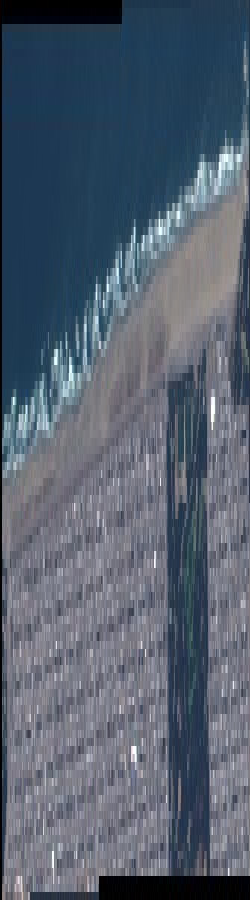

In [34]:
img = keras.preprocessing.image.load_img(
    image_path, target_size=(900,250)
)
img

In [36]:

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
score


array([1., 0.], dtype=float32)

In [37]:
label=score.argmax(axis=0)
label

0

In [38]:
save_location=os.getcwd() +os.sep + "models"
if not os.path.exists(save_location):
    os.mkdir(save_location)

In [39]:
model_save_location=save_location+os.sep + "model3"
model.save(model_save_location)

INFO:tensorflow:Assets written to: c:\1_USGS\2_Machine_Learning\1_tutorials_phase1\1_scikitlearn\models\model3\assets


In [41]:
# Write the test scores to a file
import csv
csv_file_path=os.getcwd()+os.sep+"test_results"+os.sep+"modelScores.csv"
if not os.path.exists(csv_file_path):
    with open(csv_file_path, 'w', newline='') as outcsv:
        writer = csv.writer(outcsv)
        writer.writerow(["Accuracy", "Test Loss", "Model Description"])
elif os.path.exists(csv_file_path):
    with open(csv_file_path, 'a', newline='') as outcsv:
            writer = csv.writer(outcsv)
            writer.writerow([score[1], score[0], "refined model with data pipeline 4.22.2022"])
